(page:cns)=
# Classical Coordination Number Analysis

This script calculates the coordination number (CN) for Pt atoms of an atomic configuration delivered in the `.bgf` file format. The method is referred to as "classical" CN analysis to differentiate it from other CN based approach, such as the Generalized CN method shown below. For classical CN analysis, we count the number of nearest neighbors up to a cutoff radius, $r_\mathrm{c}$, which in this case has been tuned for this specific problem (ReaxFF Pt-Pt bond legth).

First, we will retrieve the data which read in on the [setup page](page:setup) and exported to a `.csv` file.

In [81]:
import pandas as pd

data = pd.read_csv("../data/data.csv")

For this analysis method, we chose choose a non-oxdized nanoparticle. Simply pick the first entry in the list after filtering the `DataFrame` for `n_O == 0`.

In [82]:
sample = data.loc[(data["n_O"] == 0)].iloc[0]

Read in atomic coordinates as an ASE Atoms object. We use the `read_bgf` function from the [asetools package](https://gitlab.com/bjk24/asetools.git).

```{warning} At the time of writing of this tutorial, the 
`read_bgf` function can only read rectangular cells in the 
`.bgf` file format. Reading non-orthorhombic cells would 
require a coordinate system transformation which this function 
doesn't do. For a more feature-complete `.bgf` reader, see 
[John Kitchin's implementation](https://github.com/jkitchin/python-reaxff).
```

In [83]:
from asetools.systemtools import read_bgf

atoms = read_bgf(sample["root"])

Calculation of the coordination number requires a cutoff to be defined, *i.e.*, we need to define until which distance two atoms will be considered neighbors. This distance is different for different elements or pairs of elements. Adding the atomic radii plus some safety margin is often a good starting value for systems that are not significantly strained out of their equilibrium configurations.

Throughout this tutorial, we will use a cutoff radius $r_\mathrm{c}$ of 3 Å which works well for both Pt-Pt and Pt-O bonds.

In [84]:
rc = 3.0

Now we define the "probe" element. CNs will be calculated only for this element. In the static online version of this tutorial, an oxygen-free system is read in to illustrate the method and this parameter is thus not strictly necessary. However, implementing this parameter will make it easier to experiment with this method by changing the evaluated structure above if you execute this book locally.

In [85]:
probe = "Pt"

Make a list of indices of all atoms whose element matches `probe`.

```{tip} This code can easily be adapted to accept any kind of 
`probe` input. The implementation in 
[asetools](https://gitlab.com/bjk24/asetools/-/blob/main/asetools/analysis/coordinationNumbers.py)
accepts any combination of element symbols and atomic indices 
without double counting and will calculate the $r_\mathrm{c}$ 
on-the-fly from the atomic radii.
``` 

In [86]:
indices = [atom.index for atom in atoms if atom.symbol == probe]

Calculate distances to all other probe atoms for each atom. The CN corresponds to the number of distances which are < $r_\mathrm{c}$. 

For the sake of convenience, we utilize `ase.Atoms.get_distances()` instead of calculating the distances ourselves. This function will automatically respect the cell parameters and periodic boundary conditions, *i.e.*, it follows the [minimum image convention](https://en.wikipedia.org/wiki/Periodic_boundary_conditions#Practical_implementation:_continuity_and_the_minimum_image_convention) if `mic = True` is passed as an additional argument. (The `mic` parameter is not necessary in the present case because the test system is molecular). The function also uses fast `numpy` [array broadcasting operations](https://numpy.org/doc/stable/user/basics.broadcasting.html) to do simple calculations such as the Euclidian distance. So, this approach is both more convenient and faster than implementing a double for loop in python to do the distance calculation manually. 

`ase.Atoms.get_distances()` takes a list as the second argument. Hence, we can loop through the `indices` list and for each `idx`, calculate all distances to every other atom in `indices`. However, this results in a distance calculation of the current atom with itself. We therefore need to implement a filter `if d > 0` to make sure we do not count this self-interaction.

Finally, the calculated CN values are saved in a `dictionary` for later recall.

In [87]:
cnDict = {}
for idx in indices:
    dists = atoms.get_distances(idx, indices)
    cn = len([d for d in dists if d > 0 and d <= rc])
    cnDict.update({idx: cn})

```{info} The line where 
`cn` is calculated contains a 
[python list comprehension](https://www.w3schools.com/python/python_lists_comprehension.asp). 
List comprehensions are essentially one-line for-loops which can also contain conditional statements. 
While they can be a bit harder to understand at first glance, they are useful to producing more 
compact code and are also faster than for loops in most circumstances.
```

Let's have a look at a slice of the results.

In [88]:
for i, item in enumerate(cnDict.items()):
    if i < 5:
        print(item)

(0, 7)
(1, 7)
(2, 4)
(3, 7)
(4, 7)


It is a good idea to double check the range of values we generated to make sure that the choice of $r_\mathrm{c}$ was appropriate. Pt is a fcc metal, hence we expect values from 1 and 12.

In [89]:
print("lowest CN = ", min(cnDict.values()))
print("highest CN = ", max(cnDict.values()))

lowest CN =  4
highest CN =  12


Looks reasonable! So, we now have access to a dictionary where the atomic index is the `key` and the CN is the `value`. We can already use this information, for example, to visualize the CN values on the structure itself.

To visualize the CNs on the nanoparticle, we will change the element of each atom as a function of its coordination number. The `ase.data.chemical_symbols` module conveniently provides us with element symbols when passed an element number. We can then use the `x3d` viewer provided by the `ase.visualize.view` module to interactively display the thus-altered `Atoms` object in this Jupyter notebook.

The `x3d` viewer has some limitations. For example, there is no way to change the view camera; it is always pointed at the origin (0, 0, 0) viewed along the $z$ axis. In order to make the structure display properly, we therefore have to change the coordinates of the structure. Therefore, we first translate the structure so that it is centered at (0, 0, 0) and then push the structure back along the $z$ axis so that the entire structure is in view. 

In [90]:
from ase.visualize import view
from ase.data import chemical_symbols

center = atoms.cell.diagonal() / 2
atoms.translate((-1) * center)
atoms.translate([0,0,-35])

for atom in atoms:
    atom.symbol = chemical_symbols[cnDict[atom.index] + 20]

view(atoms, viewer="x3d")

To better quantify the results, it can be advantageous to generate a distribution of CN values, *i.e.*, how often each CN occurs in the analyzed structure. To this end, count the number of occurrences of each unique CN. We create yet another `dictionary` object to save the results in.

```{tip} Instead of python-based loops, the number of occurrences can also be counted by using the 
`numpy.nonzero` function if speed is of the essence. To learn more, see for example 
[how this function is implemented in asetools](https://gitlab.com/bjk24/asetools/-/blob/main/asetools/analysis/coordinationNumbers.py).
```

In [91]:
cnDist = {}
for cn in cnDict.values():
    if cn in cnDist:
        cnDist[cn] += 1
    else:
        cnDist.update({cn: 1})
print(cnDist)

{7: 84, 4: 6, 9: 168, 12: 231}


Sanity check: The most common number is 12, which corresponds to the "bulk" atoms on the inside of the particle. CN = 9 atoms constitute the (111)-indexed facets, CN = 7 are the edges, and the 6 atoms with CN = 4 are the vertex atoms at the tips of the octahedral structure. The results agree with expectations from chemical intuition.

Finally, let's visualize the results. We use `matplotlib.pyplot` to construct a bar graph to show the distribution. We make use of the reversed `zip` function which will split the `([key1, value1], [key2, value2], ...)` list-of-lists generated by `dictionary.items()` into two lists of the same length, one holding all keys and one holding all values.  

```{tip} Libraries like [seaborn](https://seaborn.pydata.org/) allow you to create even more sophisticated and beautiful data visualization. We'll keep it simple here for the sake of brevity but feel free to change the code below to make it look more impressive!
```

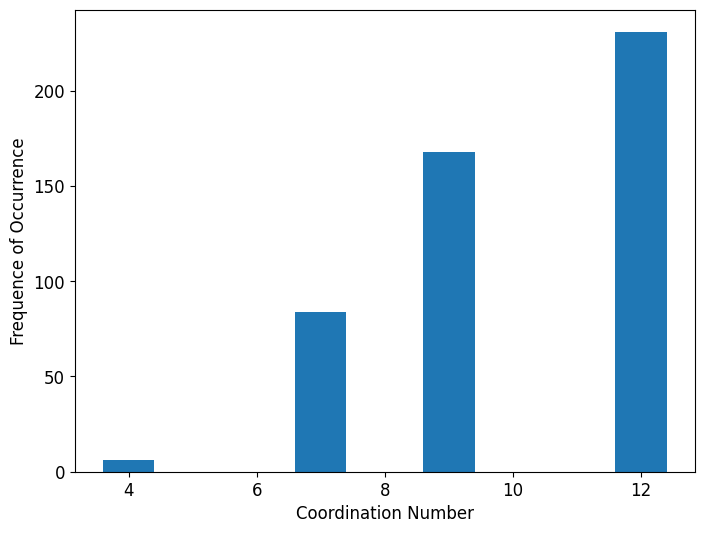

In [92]:
import matplotlib.pyplot as plt

keys, values = zip(*cnDist.items())

plt.figure(figsize=(8, 6))
plt.rcParams.update({'font.size': 12})
plt.bar(keys, values)
plt.xlabel("Coordination Number")
plt.ylabel("Frequence of Occurrence")
plt.show()

 The highest frequency of coordination numbers is found to be CN = 12, which is the coordination number of an atom in the bulk of the particle that is fully surrounded by other atoms in an *fcc* crystal. CNs of 9 and 7 indicate facet and edge atoms, respectively, and CNs of 4 correspond to atoms at vertex sites.